In [218]:
import graphinf, midynet
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, pandas as pd
import tqdm.notebook as tqdm

from midynet.utility import display
from collections import defaultdict
from scipy.integrate import quad


In [83]:
list(g0)

[(0, 2), (2, 2)]

In [107]:
N, M = 4, 4

erdos = graphinf.graph.ErdosRenyiModel(N, M, loopy=True, multigraph=True)
config = graphinf.graph.ConfigurationModelFamily(N, M, degree_prior_type="uniform")

X = graphinf.data.dynamics.GlauberDynamics(erdos, coupling=0.5, length=20)
Y = graphinf.data.dynamics.GlauberDynamics(config, coupling=0.5, length=20)
Y.from_model(X)
g0 = list(X.graph_copy().edges())

In [115]:
data = defaultdict(list)


for i, g in tqdm.tqdm(
    enumerate(graphinf.utility.enumerate_all_graphs(N, M, True, True)), 
    total=int(np.exp(-erdos.log_joint()))
):
    if list(g.edges()) == g0:
        true_idx = i
    
    X.set_graph(g)
    data["GraphId"].append(i)
    data["Model"].append("erdos")
    data["Prior"].append(-X.log_prior())
    data["Likelihood"].append(-X.log_likelihood())
    data["Posterior"].append(-X.log_posterior(method="exact"))
    data["Evidence"].append(-X.log_evidence(method="exact"))
    
    Y.set_graph(g)
    data["GraphId"].append(i)
    data["Model"].append("config")
    data["Prior"].append(-Y.log_prior())
    data["Likelihood"].append(-Y.log_likelihood())
    data["Posterior"].append(-Y.log_posterior(method="exact"))
    data["Evidence"].append(-Y.log_evidence(method="exact"))
    
# X.set_graph(g0)
# Y.set_graph(g0)

  0%|          | 0/714 [00:00<?, ?it/s]

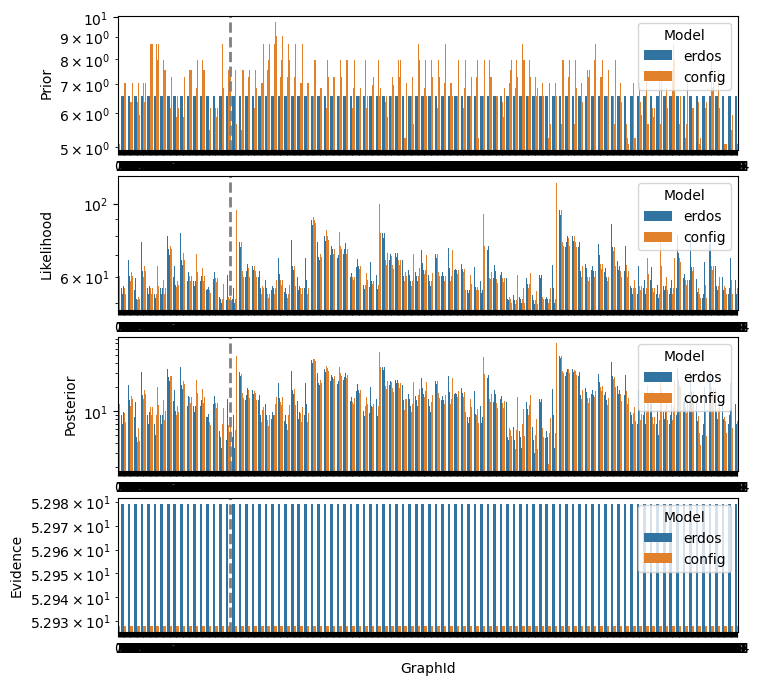

In [116]:
df = pd.DataFrame(data)

fig, ax = plt.subplots(4, 1, figsize=(8, 8))
for i, k in enumerate(["Prior", "Likelihood", "Posterior", "Evidence"]):
    sns.barplot(df, x="GraphId", y=k, hue="Model", ax=ax[i])
    ax[i].set_yscale("log")
    ax[i].axvline(true_idx, color="grey", linestyle="--", linewidth=2)

In [166]:
import pymc
from sklearn.neighbors import KernelDensity
from scipy.stats import norm


In [247]:
norm.rvs?

In [561]:
mu0, sig0 = 5, 1

muA, sigA = 0, 2
muB, sigB = 10, 0.3

x = norm.rvs(mu0, 10, size=50)

data = defaultdict(list)

with pymc.Model() as model0:
    mu = pymc.Normal("mu", mu=mu0, sigma=sig0)
    likelihood0 = pymc.Normal("likelihood", mu=mu, sigma=5, observed=x)
    trace0 = pymc.sample(1000)
    y = trace0.posterior.data_vars["mu"].values.reshape(-1)
    data["model"].extend(["0"]*len(y))
    data["prior"].extend(norm.rvs(mu0, sig0, size=len(y)))
    data["posterior"].extend(y.tolist())

with pymc.Model() as modelA:
    mu = pymc.Normal("mu", mu=muA, sigma=sigA)
    likelihoodA = pymc.Normal("likelihood", mu=mu, sigma=5, observed=x)
    traceA = pymc.sample(1000)
    y = traceA.posterior.data_vars["mu"].values.reshape(-1)
    data["model"].extend(["A"]*len(y))
    data["prior"].extend(norm.rvs(muA, sigA, size=len(y)))
    data["posterior"].extend(y.tolist())
    
with pymc.Model() as modelB:
    mu = pymc.Normal("mu", mu=muB, sigma=sigB)
    likelihoodB = pymc.Normal("likelihood", mu=mu, sigma=5, observed=x)
    traceB = pymc.sample(1000)
    y = traceB.posterior.data_vars["mu"].values.reshape(-1)
    data["model"].extend(["B"]*len(y))
    data["prior"].extend(norm.rvs(muB, sigB, size=len(y)))
    data["posterior"].extend(y.tolist())
#     log_priorB = lambda mu: np.log(norm.pdf(mu, muB, sigB))
#     kdeB = KernelDensity(bandwidth=0.1).fit(traceB.posterior.data_vars["mu"].values.reshape(-1, 1))
#     log_posteriorB = lambda mu: kdeB.score_samples(mu.reshape(-1, 1))
df = pd.DataFrame(data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [562]:
from scipy.stats import entropy, gaussian_kde

In [563]:
def kldiv(p, q, n=1000, return_max=False):
    X = p.resample(n)
    if return_max:
        return -np.mean(q.logpdf(X))
    return np.mean(p.logpdf(X) - q.logpdf(X))

def kldiv_from_samples(X, Y, return_max=False):
    kdeX = gaussian_kde(X)
    kdeY = gaussian_kde(Y)
    return kldiv(kdeX, kdeY, return_max=return_max)

log_likelihood = lambda mu: np.log(norm.pdf(x, mu, sig0)).sum()

def evi(prior, posterior, n=1000):
    p = gaussian_kde(prior)
    q = gaussian_kde(posterior)
    S = q.resample(n).squeeze()
    l = [log_likelihood(s) for s in S]
    return np.mean(p.logpdf(S) + l - q.logpdf(S))
    
evidence = {
    k: evi(df.query(f"model=='{k}'").prior, df.query(f"model=='{k}'").posterior) 
    for k in ['0', 'A', 'B']
}

info_gain = {
    k: kldiv_from_samples(df.query(f"model=='{k}'").prior, df.query(f"model=='{k}'").posterior) 
    for k in ['0', 'A', 'B']
}

Text(0.5, 0, '$\\mu$')

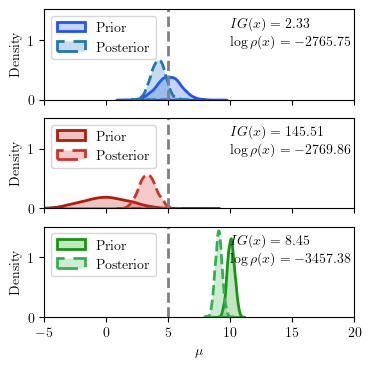

In [564]:
fig, ax = plt.subplots(3, 1, figsize=(4, 4),sharex=True, sharey=True)

for i, (idx, col) in enumerate(zip(['0', 'A', 'B'], ["blue", "red", "green"])):
    sns.kdeplot(
        df.query(f"model=='{idx}'"), 
        x="prior", 
        fill=True, 
        color=display.dark_colors[col], 
        linewidth=2, 
        ax=ax[i],
        label="Prior",
    )
    sns.kdeplot(
        df.query(f"model=='{idx}'"), 
        x="posterior", 
        fill=True, 
        color=display.med_colors[col], 
        linewidth=2, 
        ax=ax[i],
        linestyle="--",
        label="Posterior",
    )
    ax[i].axvline(mu0, linewidth=2, linestyle="--", color="grey")
    ax[i].legend(loc="upper left")
    ax[i].text(0.6, 0.8, rf"$IG(x) = {info_gain[idx]:0.2f}$", ha="left", transform=ax[i].transAxes)
    ax[i].text(0.6, 0.6, rf"$\log \rho(x) = {evidence[idx]:0.2f}$", ha="left", transform=ax[i].transAxes)
    
ax[0].set_xlim([-5, 20])
ax[-1].set_xlabel(r"$\mu$", fontsize=display.fontsizes["label"])

In [ ]:
def prior(mu, mu0=0, sig0=1):
    return norm.logpdf(mu, mu0, sig0)

def posterior(mu, s=1, x=None, mu0=0, sig0=1):
    if x is None:
        return prior(mu, mu0, sig0)
    m = x.mean()
    n = len(x)
    sig1 = 1./np.sqrt(1./sig0**2 + n/s**2)
    mu1 = 1/sig1
    return norm.logpdf(mu, )
    